In [39]:
# ! pip install -U imbalanced-learn
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from asgmnt_2_tools import lazy_read_parquet
from imblearn.under_sampling import RandomUnderSampler

#### Read in example data file using read parquet

In [9]:
root_path = "../../Data/GoogleDrive/"
df_dict_all = lazy_read_parquet(root_path)
df_heart_drop_03_imp = df_dict_all['df_heart_drop_03_imp'].collect().to_pandas()
df_heart_drop_03_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387482,Virgin Islands,Male,Good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,8.0,None of them,No,...,1.83,104.33,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
387483,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
387484,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
387485,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [29]:
# getting classes in ordinal variables
print(df_heart_drop_03_imp['GeneralHealth'].unique())
print(df_heart_drop_03_imp['LastCheckupTime'].unique())
print(df_heart_drop_03_imp['RemovedTeeth'].unique())
print(df_heart_drop_03_imp['SmokerStatus'].unique())
print(df_heart_drop_03_imp['ECigaretteUsage'].unique())
print(df_heart_drop_03_imp['AgeCategory'].unique())
# print(df_heart_drop_imp['TetanusLast10Tdap'].unique())
print(df_heart_drop_03_imp.info(max_cols=len(df_heart_drop_03_imp.columns)))

['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
['Within past year (anytime less than 12 months ago)'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']
['None of them' '1 to 5' '6 or more, but not all' 'All']
['Never smoked' 'Current smoker - now smokes some days' 'Former smoker'
 'Current smoker - now smokes every day']
['Not at all (right now)' 'Never used e-cigarettes in my entire life'
 'Use them every day' 'Use them some days']
['Age 80 or older' 'Age 55 to 59' 'Age 65 to 69' 'Age 40 to 44'
 'Age 75 to 79' 'Age 70 to 74' 'Age 60 to 64' 'Age 50 to 54'
 'Age 45 to 49' 'Age 35 to 39' 'Age 30 to 34' 'Age 25 to 29'
 'Age 18 to 24']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387487 entries, 0 to 387486
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      387487 non-nu

#### Encoding and data split

In [24]:
def encode(df):
    """
    Encodes the dataset using one-hot encoding for general categorical columns and 
    ordinal encoding for specified columns with predefined categories. Splits the data into training and test datasets.

    Parameters:
        df (pandas.DataFrame): DataFrame to encode and split.

    Returns:
      X_train_encoded (DataFrame): Encoded training features.
      X_test_encoded (DataFrame): Encoded test features.
      y_train (Series): Training target variable.
      y_test (Series): Test target variable.

    """
    # convert health days from float to int
    df['PhysicalHealthDays'] = df['PhysicalHealthDays'].astype(int)
    df['MentalHealthDays'] = df['MentalHealthDays'].astype(int)

    # Define the features and target
    X = df.drop('HadHeartDisease', axis=1)
    y = df['HadHeartDisease']
    
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.25, 
                                        random_state = 69,
                                        stratify = df['HadHeartDisease'])

    # Define which columns to one-hot encode and which to label encode
    categorical_cols = X.select_dtypes(include=['object']).columns
    one_hot_cols = categorical_cols.drop(['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 
                                          'AgeCategory', 'SmokerStatus', 'ECigaretteUsage'])
    
    

    # define the columns with specific encoding
    comp_labels = {
        "GeneralHealth": ['Poor', 'Fair', 'Good', 
                          'Very good', 'Excellent'],

        "LastCheckupTime": ['5 or more years ago',
                            'Within past 5 years (2 years but less than 5 years ago)',
                            'Within past 2 years (1 year but less than 2 years ago)',
                            'Within past year (anytime less than 12 months ago)'],

        "RemovedTeeth": ['None of them', '1 to 5',
                         '6 or more, but not all', 'All'],

        "SmokerStatus": ['Never smoked', 'Former smoker',
                         'Current smoker - now smokes some days',
                         'Current smoker - now smokes every day'],
                         
        "ECigaretteUsage": ['Never used e-cigarettes in my entire life',
                            'Not at all (right now)',
                            'Use them some days',
                            'Use them every day']
    }

    label_encoders = [(key + '_label', OrdinalEncoder(categories=[value]), [key]) 
                      for key, value in comp_labels.items()]
    
    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols),
            ('label', OrdinalEncoder(), ['AgeCategory']),
        ] + label_encoders
        , remainder='passthrough'
    )
    
    # Fit the preprocessor on the training data only and transform both
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    # fit another label encoder on y
    y_label_encoder = OrdinalEncoder()
    y_train_encoded = y_label_encoder.fit_transform(pd.DataFrame(y_train))
    y_test_encoded = y_label_encoder.transform(pd.DataFrame(y_test))

    # Handle sparse matrix if necessary
    if issparse(X_train_encoded):
        X_train_encoded = X_train_encoded.toarray()
    if issparse(X_test_encoded):
        X_test_encoded = X_test_encoded.toarray()

    # Convert the sparse matrix to DataFrame and specify column names
    X_columns = preprocessor.get_feature_names_out()
    y_column = y_label_encoder.get_feature_names_out()
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_columns, index=X_test.index)
    y_train_encoded = pd.DataFrame(y_train_encoded, columns=y_column, index=y_train.index)
    y_test_encoded = pd.DataFrame(y_test_encoded, columns=y_column, index=y_test.index)

    return X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded


Test encode() on `df_heart_drop_03_imp`

In [28]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_03_imp)
print(X_train.shape)
print(X_test.shape)
print("=============")
print(y_train.shape)
print(y_test.shape)
print("=============")
print(X_train.info())
print("===================================")
print(y_train.info())

(290615, 121)
(96872, 121)
(290615, 1)
(96872, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290615 entries, 386623 to 142253
Columns: 121 entries, onehot__State_Alabama to remainder__WeightInKilograms
dtypes: float64(121)
memory usage: 270.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290615 entries, 386623 to 142253
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   HadHeartDisease  290615 non-null  float64
dtypes: float64(1)
memory usage: 4.4 MB
None


#### Under sampling to balance data

distribution of yes and no in target before under sampling

HadHeartDisease
0.0                260572
1.0                 35453
dtype: int64


<AxesSubplot:ylabel='None'>

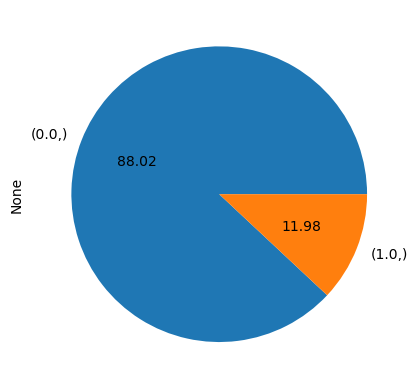

In [43]:
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%.2f')

Function for under sampling

In [41]:
# Only balance the training set
def balance(X_train, y_train):
    rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
    X_res, y_res = rus.fit_resample(X_train, y_train)
    return X_res, y_res

Distribution of yes and no in target after under sampling

HadHeartDisease
0.0                35453
1.0                35453
dtype: int64


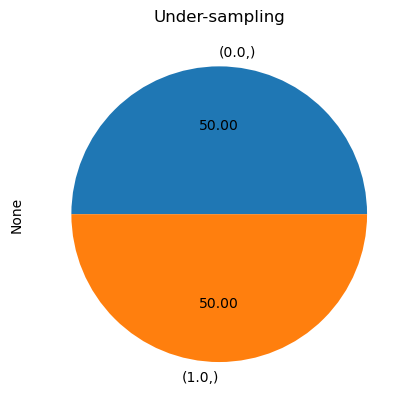

In [45]:
X_train_bal, y_train_bal = balance(X_train, y_train)
print(y_train_bal.value_counts())
ax = y_train_bal.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

#### Threshold Selection

In [46]:
# use logistic regression to select threshold
def logi_reg(X_train, X_test, y_train, y_test):
    """You know what it does 

        Input: 
            X_train: Encoded features in the training set, a pandas dataframe
            X_test: Encoded features in the test set, a pandas dataframe
            y_train: Target variable of the training set, a pandas series
            y_train: Target variable of the training set, a pandas series

        Output:
            classification_report:
            confusion_matrix:
            accuracy_score:
            roc_auc_score:
    """

    # fit logistic regression model with elastic net regularization
    log_reg = LogisticRegression(penalty = 'elasticnet',
                                solver = 'saga',
                                l1_ratio = 0.5,
                                max_iter = 1000,
                                random_state = 69)
    
    log_reg.fit(X_train, y_train)

    # predict on test set
    y_test_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]

    # Evaluate performance
    report = classification_report(y_test, y_test_pred, target_names= ['No', 'Yes'])
    matrix = confusion_matrix(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return report, matrix, accuracy, roc_auc


Test if under sampling improves performance on one dataset

In [47]:
report, matrix, accuracy, roc_auc = logi_reg(X_train_bal, X_test, y_train_bal, y_test)
print (f"The threshold for removing NAs is 3")
print('\n===============================\n'+
    'Classification report on test data' +
    '\n===============================\n')
print(report)

print('\n===============================\n'+
    'Confusion matrix on test data' +
    '\n===============================\n')
print(matrix)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 3

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     86858
         Yes       0.30      0.79      0.43     11817

    accuracy                           0.75     98675
   macro avg       0.63      0.77      0.64     98675
weighted avg       0.88      0.75      0.79     98675


Confusion matrix on test data

[[64758 22100]
 [ 2515  9302]]
Accuracy: 0.7505447175069673
ROC AUC: 0.8438916717876184



AUC improved.

#### Run a loop over thresholds and print out evaluation

Apply `encode()`, `balance()` and `logi_reg()` on all datasets and see which one has best performance

In [48]:
thresholds = [0, 1, 3, 5, 10, 20, 40]
# for creating plots later
roc_list = []
for threshold in thresholds:
    # loop through each dataset
    df = df_dict_all[f'df_heart_drop_{threshold:02}_imp'].collect().to_pandas()
    # split and encode
    X_train, X_test, y_train, y_test = encode(df)
    # under sampling to training set
    X_train_bal, y_train_bal = balance(X_train, y_train)
    # run logistic regression
    report, matrix, accuracy, roc_auc = logi_reg(X_train_bal, X_test, y_train_bal, y_test)
    roc_list.append(roc_auc)
    print (f"The threshold for removing NAs is {threshold}")
    print('\n===============================\n'+
        'Classification report on test data' +
        '\n===============================\n')
    print(report)

    print('\n===============================\n'+
        'Confusion matrix on test data' +
        '\n===============================\n')
    print(matrix)

    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)
    print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 0

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.74      0.84     54780
         Yes       0.29      0.78      0.42      7287

    accuracy                           0.75     62067
   macro avg       0.62      0.76      0.63     62067
weighted avg       0.88      0.75      0.79     62067


Confusion matrix on test data

[[40785 13995]
 [ 1625  5662]]
Accuracy: 0.7483364750994893
ROC AUC: 0.8362051897849266



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 1

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     75609
         Yes       0.29      0.78      0.43     10132

    accuracy                           0.75     85741
   macro avg       0.63      0.76      0.63     85741
weighted avg       0.88      0.75      0.79     85741


Confusion matrix on test data

[[56579 19030]
 [ 2237  7895]]
Accuracy: 0.7519623050815829
ROC AUC: 0.840144849718431



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 3

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     85306
         Yes       0.29      0.78      0.43     11566

    accuracy                           0.75     96872
   macro avg       0.63      0.76      0.63     96872
weighted avg       0.88      0.75      0.79     96872


Confusion matrix on test data

[[63560 21746]
 [ 2542  9024]]
Accuracy: 0.7492773969774548
ROC AUC: 0.8384960240721668



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 5

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     86858
         Yes       0.30      0.79      0.43     11817

    accuracy                           0.75     98675
   macro avg       0.63      0.77      0.64     98675
weighted avg       0.88      0.75      0.79     98675


Confusion matrix on test data

[[64734 22124]
 [ 2480  9337]]
Accuracy: 0.7506561945781606
ROC AUC: 0.8438537616525634



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 10

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     90857
         Yes       0.30      0.78      0.43     12370

    accuracy                           0.75    103227
   macro avg       0.63      0.76      0.64    103227
weighted avg       0.88      0.75      0.79    103227


Confusion matrix on test data

[[67924 22933]
 [ 2707  9663]]
Accuracy: 0.7516153719472619
ROC AUC: 0.8409234357090978



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 20

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     96864
         Yes       0.30      0.78      0.43     13055

    accuracy                           0.75    109919
   macro avg       0.63      0.76      0.64    109919
weighted avg       0.88      0.75      0.79    109919


Confusion matrix on test data

[[72626 24238]
 [ 2901 10154]]
Accuracy: 0.753100010007369
ROC AUC: 0.8397389626231274



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 40

Classification report on test data

              precision    recall  f1-score   support

          No       0.96      0.75      0.84     96924
         Yes       0.29      0.78      0.43     13064

    accuracy                           0.75    109988
   macro avg       0.63      0.76      0.63    109988
weighted avg       0.88      0.75      0.79    109988


Confusion matrix on test data

[[72520 24404]
 [ 2924 10140]]
Accuracy: 0.7515365312579554
ROC AUC: 0.8378899646165657



In [49]:
roc_list

[0.8362051897849266,
 0.840144849718431,
 0.8384960240721668,
 0.8438537616525634,
 0.8409234357090978,
 0.8397389626231274,
 0.8378899646165657]

#### Bar Plot of ROC AUC against thresholds

roc auc as y-axis, thresholds as x-axis

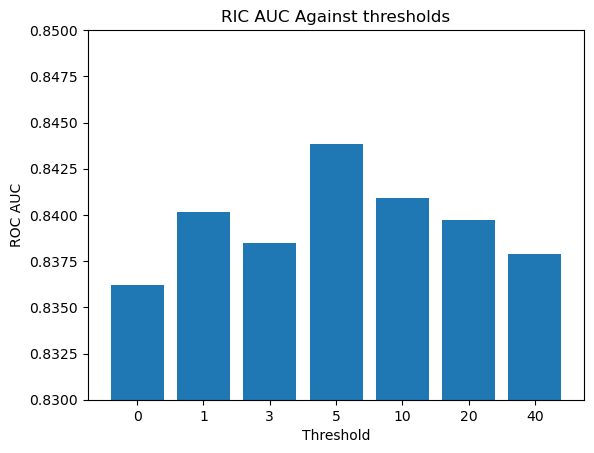

In [50]:
thresholds = [str(threshold) for threshold in thresholds]
# Create bar plot
plt.bar(thresholds, roc_list)
plt.ylim(0.83, 0.85)

# Adding the title and labels
plt.title('RIC AUC Against thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')

# Show the plot
plt.show()

Threshold = 5 results the best performance on logit.

#### Reapply encode() on the final dataset again and export

In [51]:
df_heart_drop_05_imp = df_dict_all['df_heart_drop_05_imp'].collect().to_pandas()
df_heart_drop_05_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394695,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
394696,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
394697,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
394698,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [52]:
X_train, X_test, y_train, y_test = encode(df_heart_drop_05_imp)
X_train_bal, y_train_bal = balance(X_train, y_train)
X_train_bal.to_parquet(root_path + "X_train.parquet")
X_test.to_parquet(root_path + "X_test.parquet")
y_train_bal.to_parquet(root_path + "y_train.parquet")
y_test.to_parquet(root_path + "y_test.parquet")

Test read in parquet

In [53]:
root_path = "../../Data/GoogleDrive/"
X_train_bal = pd.read_parquet(root_path + "X_train.parquet")
X_train_bal

,onehot__State_Alabama,onehot__State_Alaska,onehot__State_Arizona,onehot__State_Arkansas,onehot__State_California,onehot__State_Colorado,onehot__State_Connecticut,onehot__State_Delaware,onehot__State_District of Columbia,onehot__State_Florida,...,GeneralHealth_label__GeneralHealth,LastCheckupTime_label__LastCheckupTime,RemovedTeeth_label__RemovedTeeth,SmokerStatus_label__SmokerStatus,ECigaretteUsage_label__ECigaretteUsage,remainder__PhysicalHealthDays,remainder__MentalHealthDays,remainder__SleepHours,remainder__HeightInMeters,remainder__WeightInKilograms
90187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,1.0,0.0,3.0,0.0,8.0,1.65,113.40
262271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,0.0,0.0,1.0,0.0,5.0,16.0,1.52,88.45
98297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1.0,0.0,0.0,0.0,0.0,9.0,1.83,82.10
204106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1.0,0.0,0.0,0.0,0.0,8.0,1.55,81.65
229028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,20.0,8.0,1.57,108.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,0.0,5.0,0.0,6.0,1.63,72.57
105440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,0.0,2.0,2.0,8.0,1.57,81.19
79603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,0.0,1.0,2.0,8.0,8.0,1.75,160.12
357242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,1.70,108.86


In [54]:
y_train_bal = pd.read_parquet(root_path + "y_train.parquet")
y_train_bal

,HadHeartDisease
90187,0.0
262271,0.0
98297,0.0
204106,0.0
229028,0.0
...,...
257940,1.0
105440,1.0
79603,1.0
357242,1.0
